<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu118
cuda:0


## 数据准备

```shell
$ tree -L 2 archive 
archive
├── monkey_labels.txt
├── training
│   ├── n0
│   ├── n1
│   ├── n2
│   ├── n3
│   ├── n4
│   ├── n5
│   ├── n6
│   ├── n7
│   ├── n8
│   └── n9
└── validation
    ├── n0
    ├── n1
    ├── n2
    ├── n3
    ├── n4
    ├── n5
    ├── n6
    ├── n7
    ├── n8
    └── n9

22 directories, 1 file
```

In [32]:
!tree ../../archive 

文件夹 PATH 列表
卷序列号为 42BC-A74A
G:\WANGDAO_PYTHON_SHORT_CLASS\ARCHIVE
├─training
│  ├─n0
│  ├─n1
│  ├─n2
│  ├─n3
│  ├─n4
│  ├─n5
│  ├─n6
│  ├─n7
│  ├─n8
│  └─n9
└─validation
    ├─n0
    ├─n1
    ├─n2
    ├─n3
    ├─n4
    ├─n5
    ├─n6
    ├─n7
    ├─n8
    └─n9


In [33]:
# 导入所需的模块
from torchvision import datasets  # 用于处理图像数据集
from torchvision.transforms import ToTensor, Resize, Compose, ConvertImageDtype, Normalize  # 数据预处理的相关操作
from pathlib import Path  # 用于处理路径相关操作

# 数据集目录路径
DATA_DIR = Path("G:/wangdao_python_short_class/archive")

# 自定义数据集类，继承自 ImageFolder
class MonkeyDataset(datasets.ImageFolder): # 不同类别的图片放在不同的子目录下，每个子目录代表一个类别
    def __init__(self, mode, transform=None):
        """
        初始化方法
        :param mode: 数据集模式，可选 'train' 或 'val'
        :param transform: 数据预处理操作
        """
        # 根据 mode 设置数据集的根目录
        if mode == "train":
            root = DATA_DIR / "training"  # 训练集路径
        elif mode == "val":
            root = DATA_DIR / "validation"  # 验证集路径
        else:
            # 如果 mode 无效，则抛出异常
            raise ValueError("mode should be one of the following: train, val, but got {}".format(mode))
        
        # 调用父类的初始化方法
        super().__init__(root, transform)
        
        # 提取所有图片的标签
        # self.samples 包含 [(图片路径, 标签), (图片路径, 标签), ...]
        self.targets = [s[1] for s in self.samples]  # 将标签提取并保存到 targets 中

# 设置图片的目标尺寸
img_h, img_w = 128, 128

# 定义数据预处理的操作流水线
transform = Compose([
    Resize((img_h, img_w)),  # 将图片调整为指定尺寸
    ToTensor(),  # 将图片转换为张量格式
    Normalize([0.4363, 0.4328, 0.3291], [0.2085, 0.2032, 0.1988]),  # 对图片进行归一化处理
    ConvertImageDtype(torch.float),  # 将图片转换为浮点型数据
])

# 加载训练集和验证集
train_ds = MonkeyDataset("train", transform=transform)  # 训练集
val_ds = MonkeyDataset("val", transform=transform)  # 验证集

# 打印加载的数据集信息
print("load {} images from training dataset".format(len(train_ds)))  # 输出训练集图片数量
print("load {} images from validation dataset".format(len(val_ds)))  # 输出验证集图片数量

load 1097 images from training dataset
load 272 images from validation dataset


In [34]:
# 数据类别
train_ds.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [35]:
train_ds.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [36]:
# 图片路径及标签
i=0
for fpath, label in train_ds.samples:
    print(fpath, label)
    i += 1
    if i == 10:
        break
#
# #这个和之前的dataset完全一致
# for img, label in train_ds:
#     # c, h, w  label
#     print(img, label)
#     break

G:\wangdao_python_short_class\archive\training\n0\n0018.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0019.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0020.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0021.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0022.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0023.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0024.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0025.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0026.jpg 0
G:\wangdao_python_short_class\archive\training\n0\n0027.jpg 0


In [37]:
#因为有3通道，所有有3个mean和std
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[:, :, :].mean(dim=(1, 2))
        std += img[:, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds)) # 三通道

(tensor([ 1.5299e-04,  3.6267e-05, -6.5391e-07]), tensor([0.9999, 0.9999, 1.0002]))


In [38]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[1:2, :, :].mean(dim=(1, 2))
        std += img[1:2, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds)) # 单通道

(tensor([3.6267e-05]), tensor([0.9999]))


In [39]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[2:3, :, :].mean(dim=(1, 2))
        std += img[2:3, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([-6.5391e-07]), tensor([1.0002]))


In [40]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示计算均值后，宽和高消除（把宽和高所有的像素加起来，再除以总数）
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([ 1.5299e-04,  3.6267e-05, -6.5391e-07]), tensor([0.9999, 0.9999, 1.0002]))


In [41]:
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader    

batch_size = 64
# 从数据集到dataloader，num_workers参数不能加，否则会报错
# https://github.com/pytorch/pytorch/issues/59438
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [42]:
for imgs, labels in train_loader:
    print(imgs.shape)
    print(labels.shape)
    break
# 批次大小为64，每个批次有64张图片，图片大小为(3, 128, 128)，3为RGB通道

torch.Size([64, 3, 128, 128])
torch.Size([64])


## 定义模型

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CNN(nn.Module):
    def __init__(self, num_classes=10, activation="relu"):
        super(CNN, self).__init__()
        # 根据输入选择激活函数
        self.activation = F.relu if activation == "relu" else F.selu
        
        # 定义卷积层和池化层
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)  # 2x2的最大池化层
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        
        # 展平层
        self.flatten = nn.Flatten()
        
        # 定义全连接层
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 Xavier 均匀分布来初始化全连接层、卷积层的权重"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        """定义前向传播过程"""
        act = self.activation
        x = self.pool(act(self.conv2(act(self.conv1(x)))))  # 卷积、激活、池化
        x = self.pool(act(self.conv4(act(self.conv3(x)))))  # 卷积、激活、池化
        x = self.pool(act(self.conv6(act(self.conv5(x)))))  # 卷积、激活、池化
        x = self.flatten(x)  # 展平
        x = act(self.fc1(x))  # 第一个全连接层，激活
        x = self.fc2(x)  # 第二个全连接层
        return x  # 返回预测结果
    
# 打印模型的所有参数数量
for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")

conv1.weight	paramerters num: 864
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 4194304
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [44]:
def count_parameters(model): #计算模型总参数量
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(CNN())

4482730

In [45]:
128*16*16*128

4194304

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [46]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [47]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [48]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [49]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [50]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

activation = "relu"
model = CNN(num_classes=10, activation=activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/monkeys-cnn-{activation}")
tensorboard_callback.draw_model(model, [1, 3, img_h, img_w])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/monkeys-cnn-{activation}", save_step=len(train_loader), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/360 [00:00<?, ?it/s]

Early stop at epoch 18 / global_step 324


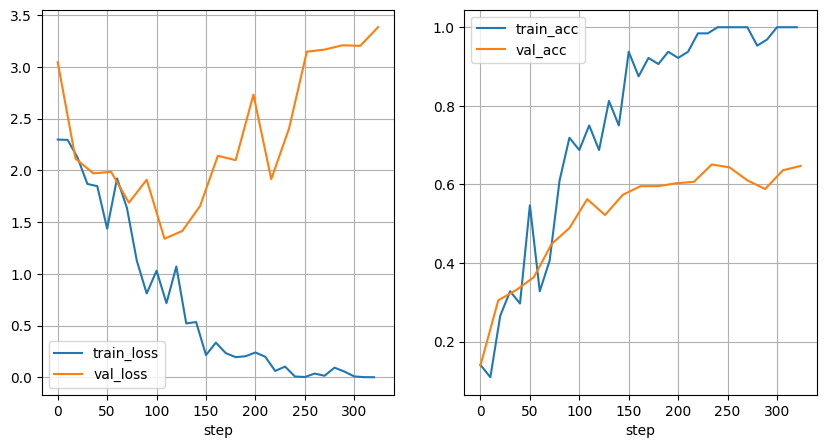

In [51]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [53]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/monkeys-cnn-{activation}/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     2.4053
accuracy: 0.6507
